# Unit operation models

| Transport Model                 | Column Dispersion | Column porosity | Particle Porosity | Film Diffusion | Pore/Surface Diffusion |
| ------------------------------- | ----------------- | --------------- | ----------------- | -------------- | ---------------------- |
| (CSTR)                          |                   |                 |                   |                |                        |
| Plug flow reactor               | x                 |                 |                   |                |                        |
| Lumped Rate model without pores | x                 | x               |                   |                |                        |
| Lumped Rate model with pores    | x                 | x               | x                 | x              |                        |
| General Rate model              | x                 | x               | x                 | x              | x                      |

# Adsorption models

At the core of chromatographic processes are interactions between the components we want to separate and a stationary
phase.

These components can be: atoms, ions or molecules of a gas, liquid or dissolved solids.

## Isotherms

These interactions can often be described in terms of an isotherm:

```{note}

**Isotherm:**
An equation that describes how much of a component is __bound__ to the stationary phase or __solved__ in the mobile phase.

Valid for a constant _temperature_ (iso - _therm_).

```

```{figure} ./resources/isotherm.png
:width: 50%
:align: center
```

In CADET, many different models for adsorption are implemented.
All of the models can be modelled kinetically or in rapid equilibrium.
Moreover, many of them include features such as competitive effects, multi state binding, or a mobile phase modifier.

```{figure} ./resources/isotherm_models.png
:width: 100%
:align: center
```

**In this lesson,** we will:

- Learn about different adsorption models.
- Associate adsorption models with different unit operations.

## Example 1: Linear model

The simplest model for adsorption is the [linear model](https://cadet.github.io/master/modelling/binding/linear.html).

Analogously to Henry's law, it describes a linear correlation between the solved concentration and the bound
concentration of the component.

Let us consider a shaking flask experiment in a `CSTR` (without ingoing or outgoing streams).
In it, we add some porous material s.t.

- the overal porosity is $0.5$.
- the volume is $1~L$

Then, we add a solution of a component with a concentration of $1~mol \cdot L^{-1}$.

Let us first create a `ComponentSystem` and a `Linear` `BindingModel`.

In [25]:
from CADETProcess.processModel import ComponentSystem, LumpedRateModelWithoutPores, Linear

component_system = ComponentSystem(1)
column = LumpedRateModelWithoutPores(component_system, "column")
column.required_parameters
column.total_porosity = 0.5
column.length = 0.1 
column.diameter = 0.1
column.axial_dispersion = 1e-20

linear = Linear(component_system)
linear.parameters
linear.adsorption_rate = 2
linear.desorption_rate = 1

column.binding_model = linear

In [26]:
from CADETProcess.processModel import Inlet, Outlet

inlet = Inlet(component_system, "inlet")
inlet.flow_rate = 0

outlet = Outlet(component_system, "outlet")

In [27]:
column.c = 1

In [28]:
column.solution_recorder.write_solution_bulk = True
column.solution_recorder.write_solution_solid = True

Now, create a `FlowSheet` and a `Process` and a `simulator`

In [36]:
column.solution_recorder.write_solution_bulk = True
column.solution_recorder.write_solution_solid = True

from CADETProcess.processModel import FlowSheet, Process
from CADETProcess.simulator import Cadet

flow_sheet = FlowSheet(component_system, "flow_sheet")
flow_sheet.add_unit(column)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(outlet)
flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

process = Process(flow_sheet, "process")
process.cycle_time = 3

In [41]:
simulator = Cadet()
simulator.time_resolution = 0.1
simulation_results = simulator.simulate(process)

In [42]:
simulation_results.solution

{'column': {'inlet': <CADETProcess.solution.SolutionIO at 0x22f29cd2cd0>,
  'outlet': <CADETProcess.solution.SolutionIO at 0x22f2884ff90>,
  'bulk': <CADETProcess.solution.SolutionBulk at 0x22f28d7bd50>,
  'solid': <CADETProcess.solution.SolutionSolid at 0x22f29c849d0>},
 'inlet': {'inlet': <CADETProcess.solution.SolutionIO at 0x22f287e3cd0>,
  'outlet': <CADETProcess.solution.SolutionIO at 0x22f287e27d0>},
 'outlet': {'inlet': <CADETProcess.solution.SolutionIO at 0x22f28d95c10>,
  'outlet': <CADETProcess.solution.SolutionIO at 0x22f28d97a50>}}

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='$time~/~min$', ylabel='$c~/~mM$'>)

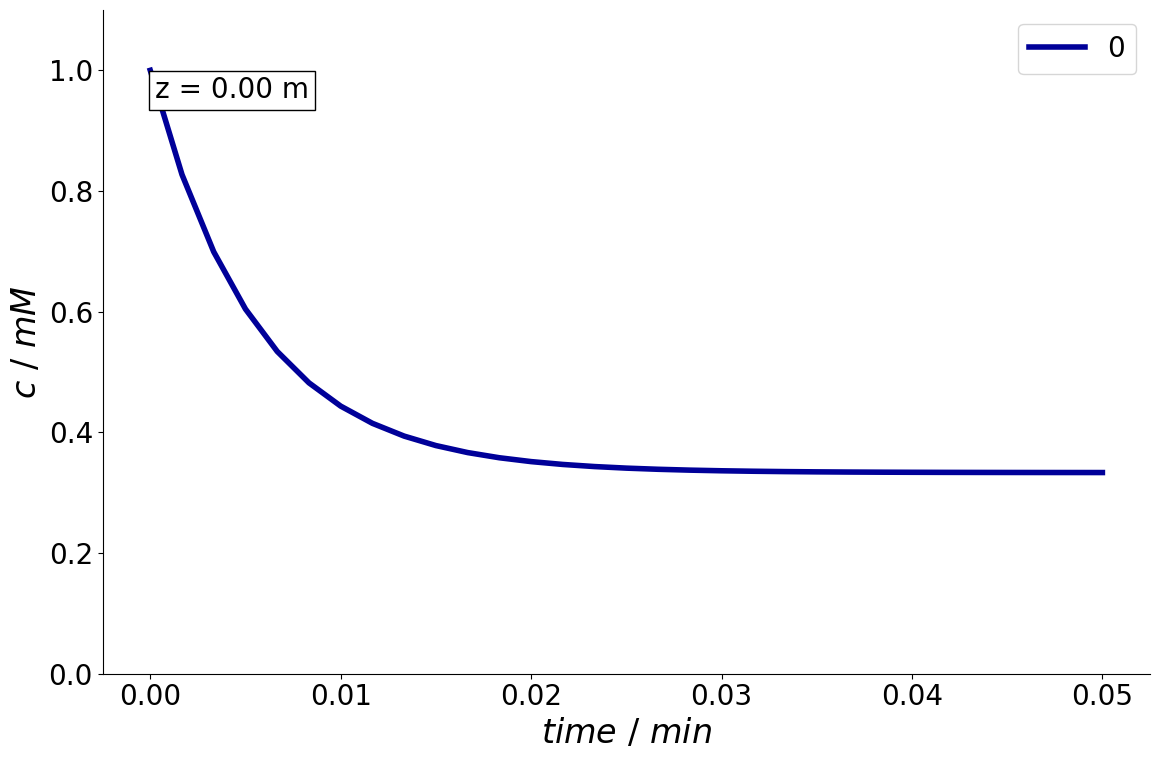

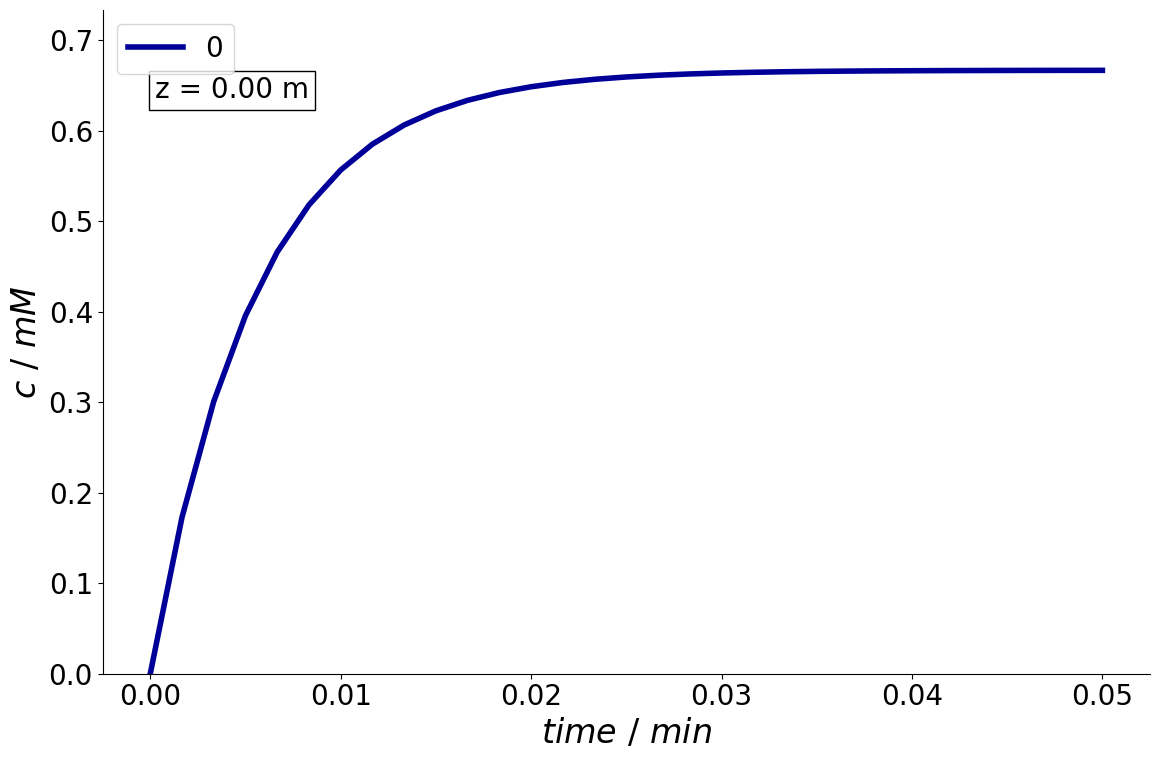

In [43]:
simulation_results.solution.column.bulk.plot_at_position(0.001)
simulation_results.solution.column.solid.plot_at_position(0.001)

### A note on resolution

As can be seen in the figure abore, the time resolution is not sufficiently high.
By default, CADET-Process stores 1 sample per second.
To increase the resolution, set the `time_resolution` parameter of the `Simulator`.

Now, the solution looks much smoother.

## Example 2: Linear adsorption model with linear concentration gradient

To plot the solid phase concentration as a function of the bulk concentration, we can introduce a linear concentration
gradient to the `LumpedRateModelWithoutPores` that has an initial concentration of $0~mM$.

We can now reproduce the "isotherm" plot from earlier (c_solid over c_bulk):

## Example 3: Multi component Langmuir model

Usually, the linear isotherm can only be assumed for very low solute concentrations.
At higher, higher concentrations the limited number of available binding sites on the surface of the adsorbent also
needs to be considered which
the [Langmuir equation](https://cadet.github.io/master/modelling/binding/multi_component_langmuir.html) takes into
account.

$$q = q_{sat} \cdot \frac{b \cdot c}{1 + b \cdot c}$$

***with:***

- $q_{Sat}$ = saturation loading
- $b$ = equilibrium factor

***Assumptions:***

- All of the adsorption sites are equivalent, and each site can only accommodate one molecule
- The surface is energetically homogeneous
- Adsorbed molecules do not interact
- There are no phase transitions
- At the maximum adsorption, only a monolayer is formed

For this example, we will again use a oncentration gradient on the `LumpedRateModelWithoutPores`.
We consider two components, both with an inital concentration of $0~mM$, but with different binding strengths:
```
adsorption_rate = [10,5]
desorption_rate = [1,1]
```

To start: create a `ComponentSystem`

In [30]:
from CADETProcess.processModel import ComponentSystem, Inlet, Outlet, LumpedRateModelWithoutPores, Langmuir
component_system = ComponentSystem(2)

inlet = Inlet(component_system, "inlet")
inlet.flow_rate = 1e-6
inlet.c = [[0, 0.01, 0, 0], [0, 0.01, 0, 0]]


(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='$time~/~min$', ylabel='$c~/~mM$'>)

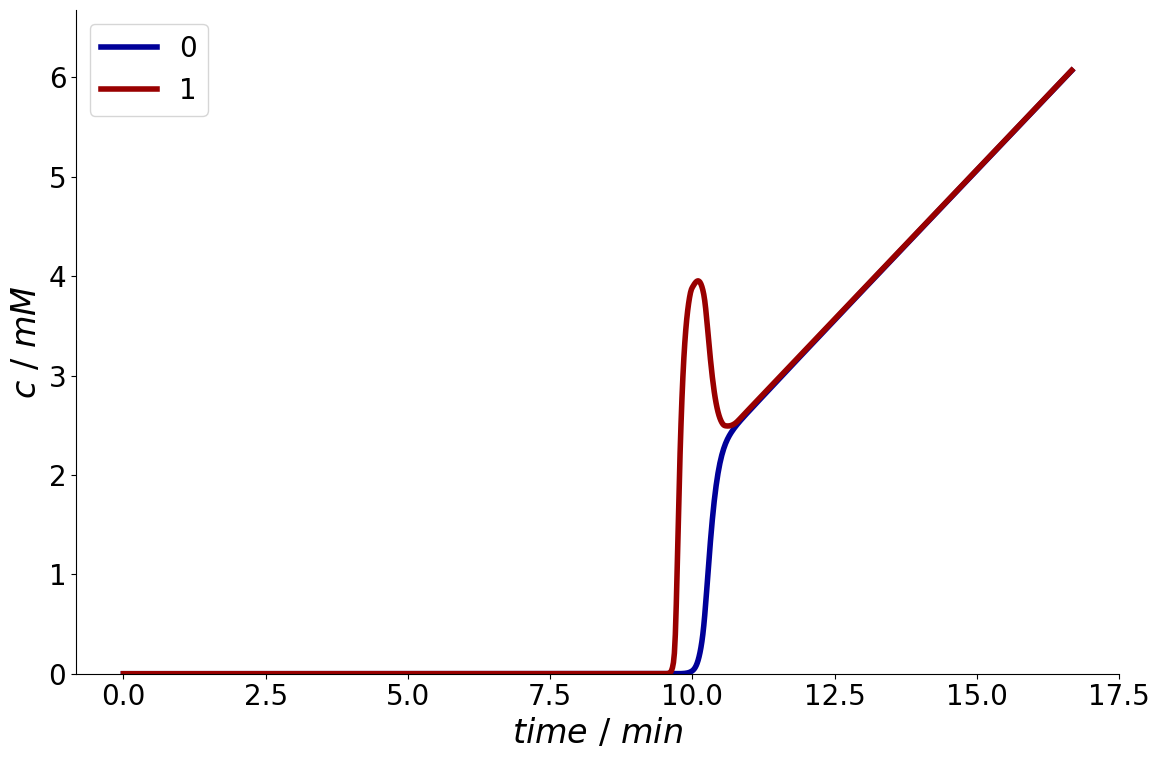

In [31]:

outlet = Outlet(component_system, "outlet")

column = LumpedRateModelWithoutPores(component_system, "column")#
column.total_porosity = 0.5
column.length = 0.1 
column.diameter = 0.1
column.axial_dispersion = 1e-20

binding = Langmuir(component_system, "binding")
binding.adsorption_rate = [10, 5]
binding.desorption_rate = [1, 1]
binding.capacity = [1, 1]

column.binding_model = binding

column.solution_recorder.write_solution_bulk = True
column.solution_recorder.write_solution_solid = True

from CADETProcess.processModel import FlowSheet, Process
from CADETProcess.simulator import Cadet

flow_sheet = FlowSheet(component_system, "flow_sheet")
flow_sheet.add_unit(column)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(outlet)
flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

process = Process(flow_sheet, "process")
process.cycle_time = 1000

simulator = Cadet()
simulation_results = simulator.simulate(process)
simulation_results.solution.outlet.outlet.plot()

We can again plot the solutions as the isotherm plot:

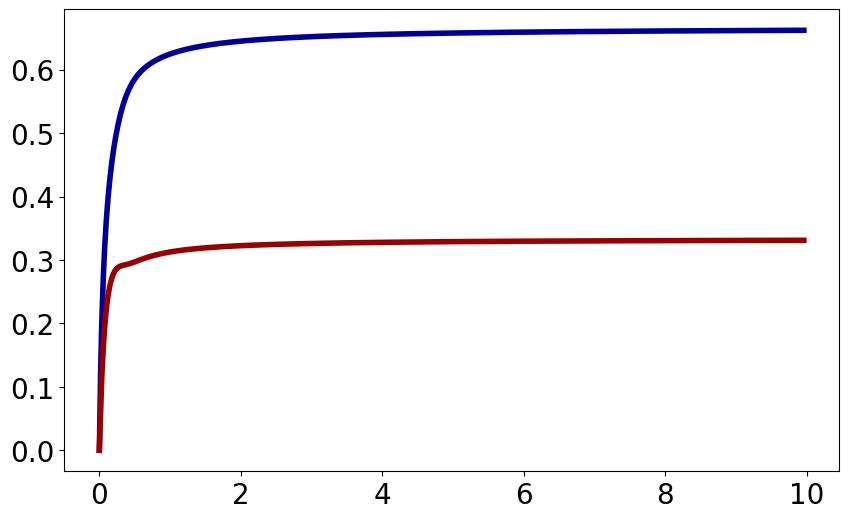

In [32]:
solid = simulation_results.solution.column.solid.solution
bulk = simulation_results.solution.column.bulk.solution

solid_slice = solid[0:1001, 0, 0:2] 
bulk_slice = bulk[0:1001, 0, 0:2] 

import matplotlib.pyplot as plt

plt.plot(bulk_slice, solid_slice)

## Exercise time

## Details on the Steric Mass Action law binding

The [Steric Mass Action model](https://cadet.github.io/master/modelling/binding/steric_mass_action.html#steric-mass-action-model) takes charges of the molecules into account and is, thus, often used in ion-exchange chromatography.
Each component has a characteristic charge $\nu$ that determines the number of available binding sites $\Lambda$ (ionic capacity) used up by a molecule.
Due to the molecule’s shape, some additional binding sites (steric shielding factor $\sigma$) may be shielded from other molecules and are not available for binding.

![image.png](attachment:87f8dbef-ecb4-4753-a596-5908d66d2cdd.png)

The model is given by this eqution:

$$\frac{\mathrm{d} q_i}{\mathrm{d} t} = k_{a,i} c_{p,i}\bar{q}_0^{\nu_i} - k_{d,i} q_i c_{p,0}^{\nu_i}$$

where $c_{p,0}$ denotes the mobile phase salt concentration, and

$$\bar{q}_0 = \Lambda - \sum_{j=1}^{N_{\text{comp}} - 1} \left( \nu_j + \sigma_j \right) q_j$$

is the number of available binding sites.

Using the parameter transformation

$$k_{a,i} = \tilde{k}_{a,i} q_{\text{ref}}^{-\nu_i}$$

$$k_{d,i} = \tilde{k}_{d,i} c_{\text{ref}}^{-\nu_i}$$

we obtain the modified model equation:

$$\frac{\mathrm{d} q_i}{\mathrm{d} t} = \tilde{k}_{a,i} c_{p,i} \left(\frac{\bar{q}_0}{q_{\text{ref}}}\right)^{\nu_i} - \tilde{k}_{d,i} q_i \left(\frac{c_{p,0}}{c_{\text{ref}}}\right)^{\nu_i}$$

This transformation serves as a (partial) nondimensionalization of the adsorption and desorption rates.

The basic goal is to have $\left(\frac{\bar{q}_0}{q_{\text{ref}}}\right) \leq 1$ and $\left(\frac{c_{p,0}}{c_{\text{ref}}}\right) \leq 1$

Recommended choices for $c_{\text{ref}}$ are the average or maximum inlet concentration of the mobile phase modifier $c_0$, and for $q_{\text{ref}}$ the ionic capacity $\Lambda$.
Note that setting the reference concentrations to ${1.0}$ each results in the original binding model.

```{note}
From a practical perspective, modern resins have a very high capacity and large proteins can can have a very high charactistic charge.
If the concentration is not normalized, the system is often numerically unstable.
It may run slowly or not at all.
```